In [1]:
#Cold dipole solution with grad(phi) = 0 at the coil  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import Dipole_Tools as dt
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix, linalg as sla
from scipy.interpolate import RectBivariateSpline
from numba import jit, njit, prange
from matplotlib import rc
rc('text',usetex=True)

In [3]:
#Set-up of the grid according to the traps geometry, the boundary conditions and natural constants
#Apex config
R_coil = 15.3/2  #coil radius APEX trap
dR_coil = 2.1 
R_wall = 3*R_coil #20 
H = 2*R_coil #13 

c = 2.99e10 #Speed of light
e = 1.602e-20*c #elementary charge
q = -e #electron charge
me = 9.109e-28 #electron mass

#B0 = 1 #Magnetic field B(r=0, z=0) due to the inner coil in Tesla
I = 54e3*0.1*c #Current in the inner coil of APEX Trap
T0 = 1e7*1.602e-19 #Plasma temperature (1 eV in erg)
omega = 1e6 #Rotation frequency in rad/s
N0 = 1e10 #Total Number of particles

res_r = 3000 # Radial number of grid points
res_z = 1000 # Longitudinal number of grid points

filename_load = 'GTE'
filename_save = 'GTE'

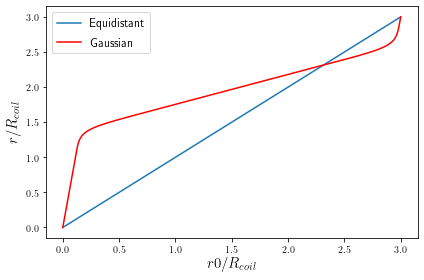

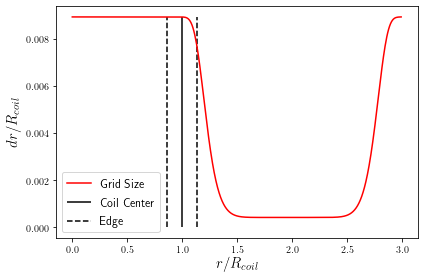

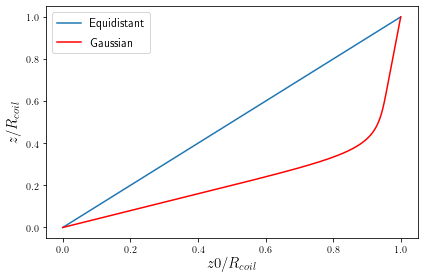

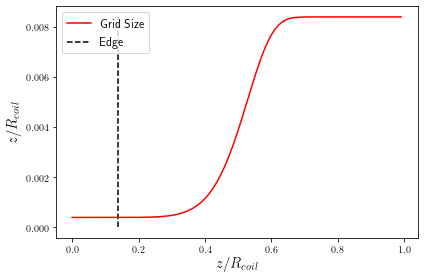

0.06829522846599072 0.06421521475137192
0.0032521537364757483 0.0030578673691130905


In [4]:
def spacing_r(r, dr, R_wall, R_coil, res_r):
    
    sigma_dr = (R_wall-R_coil)/2.5#Width of the gaussian
    #APEX
    dr0 = 2.68*R_wall/res_r #Diastance of the first grid points. I chose this value so that sum(dr) = R_wall
    #Cold
    dr0 = 8.49*R_wall/res_r #Diastance of the first grid points. I chose this value so that sum(dr) = R_wall
    #Matt
    #dr0 = 2.85*R_wall/res_r #Diastance of the first grid points. I chose this value so that sum(dr) = R_wall
    dr_min = dr0*0.05 #Minimal Distance of two grid points
    R_exp = (R_wall+R_coil)/2 #Maxima of the super-gaussian = minima in grid spacing
    exp_r = 10
    
    if len(dr) == 0:
        dr = 2*[dr0+dr_min]
        r = [R_wall, R_wall-dr0]
    dr_i = 2*dr[-1] - dr[-2] #of the next grid point to calculate the corresponding spacing
    dr.append(dr0*(1-np.exp(-(r[-1]-dr[-1]-R_exp)**exp_r/(sigma_dr**exp_r)))+dr_min) #and I need the spacing
    r.append(r[-1]-dr[-1])
    
    return r, dr

def spacing_z(z, dz, R_coil, H, res_z):
    
    #APEX
    #sigma_dz = H/3
    #dz0 = 11.1*H/res_z
    #dz_min = 0.02*dz0
    #Cold
    sigma_dz = H/4
    dz0 = 4*H/res_z
    dz_min = 0.05*dz0
    exp_z = 8

    if len(dz) == 0:
        dz = 2*[dz0+dz_min]
        z = [H/2, H/2-dz0]
    dz_i = 2*dz[-1] - dz[-2]
    dz.append(dz0*(1-np.exp(-(z[-1]-dz[-1])**exp_z/(2*sigma_dz**exp_z)))+dz_min)
    z.append(z[-1]-dz[-1])
        
    return z, dz

r, z, dr, dz, r0, z0 = dt.grid(R_coil, R_wall, H, res_r, res_z, spacing_r, spacing_z, 1)
show = dt.check_grid(r, z, r0, z0, R_coil, dR_coil, dr, dz, res_r, res_z)
print(np.max(dr), np.max(dz))
print(np.min(dr), np.min(dz))

In [5]:
z_ue = abs(z-dR_coil/2) #height of the upper edge of the coil 
i_ue = np.argmin(z_ue) #index of the upper edge of the coil
i_le = 0
r_ie = abs(r-(R_coil-dR_coil/2)) #radius of the inner edge of the coil 
i_ie = np.argmin(r_ie) #index of the inner edge of the coil 
r_oe = abs(r-(R_coil+dR_coil/2)) #radius of the outer edge of the coil 
i_oe = np.argmin(r_oe) #index of the outer edge of the coil
i_coil = np.argmin(abs(r-(R_coil))) #index of the outer edge of the coil
i_bottom = np.argmin(abs(r-(r[i_oe]+r[-1])/2)) #Index of the radius in between coil and wall 
                                               #(approximatly the bottom of the potential well)
i_mid = np.argmin(abs(z))

In [6]:
mask = np.zeros((res_r, res_z)) #Grid points with mask[i, j] = 1 are handled as electrodes 

data, col, row = dt.laplace_electrodes(r, dr, dz, mask)
A = csc_matrix((data, (col, row)), shape=(res_r*res_z, res_r*res_z))
del data, col, row 
lu = sla.splu(A)

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'rz' of function 'AGM_Dipole'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "Dipole_Tools_1D.py", line 357:
@njit(parallel = True)
def AGM_Dipole(itr, r, z, rz, dz, C,res_r, res_z, R):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


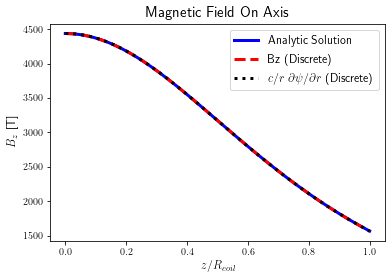

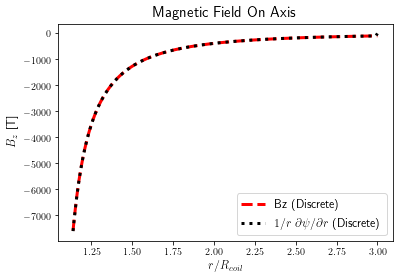

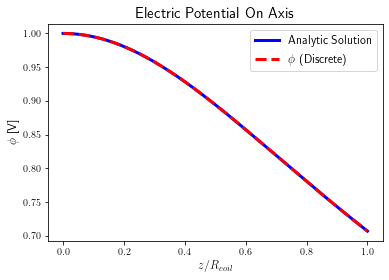

In [7]:
C = (2*I/c) #Scaling factor for Magnetic field/flux
Field_in = 0
if Field_in == 0:
    rz = np.meshgrid(z, r)
    psi, Bz, Br, phi_coil =  dt.AGM_Dipole(20, r, z, rz, dz, C, res_r, res_z, R_coil)
    Bz[0, :] = Bz[1, :]
    np.savetxt('psi_cold.txt', psi)
    np.savetxt('Bz_cold.txt', Bz)
    np.savetxt('Br_cold.txt', Br)
    np.savetxt('phi_coil_cold.txt', phi_coil)
    del  rz
elif Field_in == 1:
    psi = np.loadtxt('psi_cold.txt')
    Bz = np.loadtxt('Bz_cold.txt')
    Br = np.loadtxt('Br_cold.txt')
    phi_coil = np.loadtxt('phi_coil_cold.txt')

#Check if derivative of flux with respect to the radius equals Bz
dpsi_dr_dis = np.zeros((res_r, res_z))
for i in range(1, res_r-1):
    dr_i = (dr[i-1]+dr[i])*r[i]
    for j in range(res_z):
        dpsi_dr_dis[i, j] = (psi[i+1, j] - psi[i-1, j])/(dr_i)
#Check if Bz equals analytic solution along the axis
Bz_ana = C*np.pi*R_coil**2/(z**2+R_coil**2)**(3/2)

plt.plot(z/R_coil, Bz_ana, 'b', label='Analytic Solution', linewidth=3)
plt.plot(z/R_coil, Bz[0, :], 'r', label='Bz (Discrete)', linewidth=3, linestyle='dashed')
plt.plot(z/R_coil, dpsi_dr_dis[2, :], 'k', label='$c/r \ \partial \psi/\partial r$ (Discrete)', linestyle='dotted', linewidth=3)
plt.legend(fontsize = 12)
plt.xlabel('$z/R_{coil}$', fontsize=12)
plt.ylabel('$B_z$ [T]', fontsize=12)
plt.title('Magnetic Field On Axis', fontsize=15)
#plt.savefig('Bz_check.png', dpi = 400)
plt.show()

#Check is magnetic field and magnetic flux are consistent in the equatorial plane
plt.plot(r[i_oe:]/R_coil, Bz[i_oe:, 0], 'r', label='Bz (Discrete)', linewidth=3, linestyle='dashed')
plt.plot(r[i_oe:]/R_coil, dpsi_dr_dis[i_oe:, 0], 'k', label='$1/r \ \partial \psi/\partial r$ (Discrete)', linestyle='dotted', linewidth=3)
plt.legend(fontsize = 12)
plt.xlabel('$r/R_{coil}$', fontsize=12)
plt.ylabel('$B_z$ [T]', fontsize=12)
plt.title('Magnetic Field On Axis', fontsize=15)
#plt.savefig('Bz_check.png', dpi = 400)
plt.show()

#Check if coil potential equals analytic solution along the axis
phi_ana = 1/np.sqrt(z**2+R_coil**2)

plt.plot(z/R_coil, phi_ana/np.max(phi_ana), 'b', label='Analytic Solution', linewidth=3)
plt.plot(z/R_coil, phi_coil[0, :]/np.max(phi_coil[0, :]), 'r', label='$\phi$ (Discrete)', linewidth=3, linestyle='dashed')
plt.legend(fontsize = 12)
plt.xlabel('$z/R_{coil}$', fontsize=12)
plt.ylabel('$\phi$ [V]', fontsize=12)
plt.title('Electric Potential On Axis', fontsize=15)
#plt.savefig('Bz_check.png', dpi = 400)
plt.show()

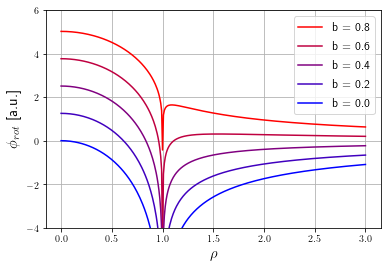

In [8]:
#Plot potential of unbound coil with different amounts of charge on the coil
plt.plot(r/R_coil, 0.8*phi_coil[:, 0] - c*psi[:, 0]/(I*R_coil), label = 'b = 0.8', color = (1, 0, 0, 1))
plt.plot(r/R_coil, 0.6*phi_coil[:, 0] - c*psi[:, 0]/(I*R_coil), label = 'b = 0.6', color = (0.75, 0.0, 0.25, 1))
plt.plot(r/R_coil, 0.4*phi_coil[:, 0] - c*psi[:, 0]/(I*R_coil), label = 'b = 0.4', color = (0.5, 0.0, 0.5, 1))
plt.plot(r/R_coil, 0.2*phi_coil[:, 0] - c*psi[:, 0]/(I*R_coil), label = 'b = 0.2', color = (0.25, 0.0, 0.75, 1))
plt.plot(r/R_coil, 0.0*phi_coil[:, 0] - c*psi[:, 0]/(I*R_coil), label = 'b = 0.0', color = (0, 0, 1, 1))
plt.legend(fontsize = 12)
plt.ylim(-4, 6)
plt.grid()
plt.ylabel(r'$\phi_{rot}$ [a.u.]', fontsize = 15)
plt.xlabel(r'$\rho$', fontsize = 15)
plt.savefig('Steinbrunner_Fig1.png', format = 'png', bbox_inches="tight", dpi=300)
plt.savefig('Steinbrunner_Fig1.tif', format = 'tif', bbox_inches="tight", dpi=300)
plt.show()

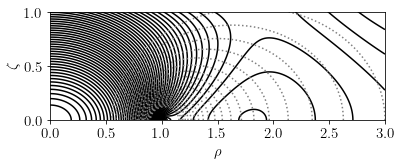

0.0026293714290683296


In [9]:
#Plot 2D vacuum potential in the rotating frame
cent = -np.transpose((me*omega**2/(2*q))*np.array(res_z*[r**2])) #Effective centrifugal potential
cent[0, :] = 0
b = 0.8
scale = omega*I*R_coil/c**2
boundary_top = phi_coil[:, -1] 
boundary_out = phi_coil[-1, :]
f_wall = np.zeros((res_r, res_z))
f_wall[-1, :] = -boundary_out*(1/r[-1]+2/dr[-1])/(dr[-2] + dr[-1])
f_wall[:, -1] += -2*boundary_top/((dz[-1] + dz[-2])*dz[-1])
phi_wall = lu.solve(f_wall.flatten())
phi_wall = dt.array22d(phi_wall, res_r, res_z)
phi_trap = b*scale*(phi_coil - phi_wall)
phi_rot = -phi_trap + (omega/c)*psi + cent

mask, phi_well = dt.well(-phi_rot, res_r, res_z, i_oe, i_mid, i_bottom, 0)
depth_vac = phi_well-np.min(-phi_rot[i_oe:, 0])

mini = psi[-1, 0]/(C*R_coil)
maxi = psi[i_oe, 0]/(C*R_coil)
contours_psi = np.arange(mini, maxi, (maxi-mini)/20)

maxi = np.max(phi_rot)*1.2
mini = np.min(phi_rot)
contours = np.arange(mini, maxi, (maxi-mini)/100)

fig, ax = plt.subplots(figsize=(6, 2))
im = ax.contour(r/R_coil, z/R_coil, np.transpose(phi_rot), contours, colors='k', linestyles = 'solid')
im_mask = ax.contour(r/R_coil, z/R_coil, np.transpose(psi/(C*R_coil)), contours_psi, colors='gray', linestyles = 'dotted')
ax.set_xlabel(r"$\rho$", fontsize = 15)
ax.set_ylabel(r"$\zeta$", fontsize = 15)
ax.tick_params(labelsize=15)
#plt.tight_layout()
plt.savefig('Steinbrunner_Fig3.png', format = 'png', bbox_inches="tight", dpi=300)
plt.savefig('Steinbrunner_Fig3.tif', format = 'tif', bbox_inches="tight", dpi=300)
plt.show()

print(np.max(cent)/depth_vac)
del f_wall, phi_wall

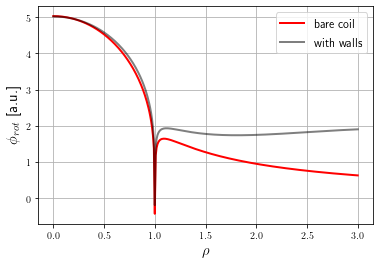

In [10]:
plt.plot(r/R_coil, 0.8*phi_coil[:, 0] - c*psi[:, 0]/(I*R_coil), label = 'bare coil', color = (1, 0, 0, 1), linewidth = 2)
plt.plot(r/R_coil, -phi_rot[:, 0]/scale+3, label = 'with walls', color = (0, 0, 0, 0.5), linewidth = 2)
plt.legend(fontsize = 12)
plt.grid()
plt.ylabel(r'$\phi_{rot}$ [a.u.]', fontsize = 15)
plt.xlabel(r'$\rho$', fontsize = 15)
plt.savefig('Steinbrunner_Fig2.png', format = 'png', bbox_inches="tight", dpi=300)
plt.savefig('Steinbrunner_Fig2.tif', format = 'tif', bbox_inches="tight", dpi=300)
plt.show()

In [11]:
#T = T0*np.array([0.0, 0.5, 0.1, 0.02]) 
T = T0*np.array([]) 

for i in range(len(T)):
    if T[i] == 0.0:
        itr = 3000
        cooling = 0
        frac = 0.1 #Trap is partially filled for zero-temperature limit
        f_2d = np.zeros((res_r, res_z))
        phi = f_2d.flatten()
        f = f_2d.flatten()
        phi_tot = phi_rot.copy()

        mask, phi_well = dt.well(-phi_tot, res_r, res_z, i_oe, i_mid, i_bottom, depth_vac*frac)
        mask[i_ie:i_oe, i_le:i_ue] = 0
        diff = 1e30 #Initialize difference between iteration, I use that as a measure of the convergence
        sum_error = 1e30
    else:
        itr = 1500
        frac = 0.0 #Use entire potential well for finite temperature solutions
        f_2d = np.loadtxt(filename_load+'_T'+str(round(T[i-1]/T0, 2))+'distribution.txt')
        phi_2d = np.loadtxt(filename_load+'_T'+str(round(T[i-1]/T0, 2))+'potential.txt')
        F0 = dt.N_tot(f_2d, r, z, dr, dz, res_r, res_z)
        N0 = F0/(4*np.pi*e)
        #print('N = %1.2e' %(N0))
        f = f_2d.flatten()
        phi = phi_2d.flatten()
        phi_tot = phi_2d + phi_rot
        mask, phi_well = dt.well(-phi_tot, res_r, res_z, i_oe, i_mid, i_bottom, depth_vac*frac)
        mask[i_ie:i_oe, i_le:i_ue] = 0 
        if T[i]/T0 <= 0.2:
            cooling = 1
            itr = 5000
        else:
            cooling = 0
            itr = 1500            

    delta = 0.001   #Step width for the change of the potentiall from one iteration to the next
    ddelta = 0.01*delta #Change of step width if error decreases
    delta_min = 0.01*delta #Minimum Step width
    Error = np.zeros((itr))
    Diff = np.zeros((itr))
    Delta = np.zeros((itr))
    sum_error = 1e20
    diff = 1e30
    T_i = T[i]

    for m in range(itr):

        if cooling == 1 and m <= itr//2:
            T_i = (1-2*m/itr)*T[i-1] + (2*m/itr)*T[i]
        f0 = f  #Save last distribution and calculate new Boltzmann distribuion from old potential
        if T_i == 0:
            mask, phi_well = dt.well(-phi_tot, res_r, res_z, i_oe, i_mid, i_bottom, depth_vac*frac)
            f_2d = mask*2*omega*(q*Bz/(me*c)-omega)*me/e
        else:
            f_2d = dt.GTE(phi_tot, q, mask, T_i, F0, r, z, dr, dz, res_r, res_z, i_ie, i_oe, i_le, i_ue)
        f_2d = np.nan_to_num(f_2d)
        f = f_2d.flatten()
        
        d2phi = A.dot(-phi)
        sum_error0 = sum_error
        sum_error = abs(dt.N_error(d2phi, f, mask, r, z, dz, e, res_r, res_z))
        Error[m] = np.nan_to_num(sum_error) #Add error to list                           

        diff0 = diff #Save old difference
        diff = np.sum(abs(f-f0)) #Calculate new difference
        Diff[m] = np.nan_to_num(np.sum(diff)) #Add difference to list
        Delta[m] = np.nan_to_num(np.sum(delta))

        #if sum_error/100 > sum_error0 and T[i]/T0 == 0.02:
        #    T = T + 0.08*T0*4/itr
            
        phi1 = lu.solve(delta*f+(1-delta)*f0)
        phi = phi1*delta + (1-delta)*phi #Solve Poissons Equation
        if sum_error <= sum_error0:
            #phi1 = lu.solve(delta*f+(1-delta)*f0)
            phi1 = lu.solve(f)
            phi = phi1*delta + (1-delta)*phi #Solve Poissons Equation
            delta += ddelta
        else:
            phi1 = lu.solve(f0)
            phi = phi1*delta + (1-delta)*phi
            delta = np.max((delta-2*ddelta, delta_min))
        phi = np.nan_to_num(phi)
        phi_2d = dt.array22d(phi, res_r, res_z)     
        phi_tot = phi_2d + phi_rot
        if T[i] != 0.0:
            phi_mean = np.mean(phi_tot[mask==1])
            phi_tot = phi_tot - phi_mean
        
        if m%500 == 0:# or T == 0:
            #print('T = %1.2f eV' %(T/T0))
            print('Iteration ', m)
            print('Error = %1.2e' %(sum_error))
            print('delta = %1.2e' %(delta))
            print('')
            #mask, phi_well = dt.well(-phi_tot, res_r, res_z, i_oe, i_mid, i_bottom, depth_vac*frac)
            #mask[i_ie:i_oe, i_le:i_ue] = 0           
    phi_tot = phi_2d + phi_rot
    n_2d = f_2d/(4*np.pi*e)
    n_2d[i_ie:i_oe, i_le:i_ue] = 0
    mask, phi_well = dt.well(-phi_tot, res_r, res_z, i_oe, i_mid, i_bottom, 0)
    show = dt.plot_2d(n_2d, phi_tot/np.max(phi_tot), mask, r, z, R_coil, R_wall, i_ie, i_oe, i_le, i_ue, res_r, res_z)

    fig, ax1 = plt.subplots()
    color = 'b'
    ax1.set_ylabel('$\delta$', color=color, fontsize = 15)
    ax1.plot(Delta, label='Stepsize', color = 'b')
    ax1.tick_params(axis='y', labelcolor=color)
    plt.yscale('log')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-ax
    color = 'r'
    ax2.set_ylabel('$\int dV |\epsilon_0/q \Delta\phi_i+n_i|$', color=color, fontsize = 15)
    ax2.plot(Error, label='Error', color = 'r')
    ax2.tick_params(axis='y', labelcolor=color)
    plt.yscale('log')
    plt.grid()
    fig.legend(loc = (0.57, 0.6), fontsize = 12)
    plt.title('Error and Convergence', fontsize = 15)
    #plt.savefig('Error_Convergence.jpg', dpi = 400)
    plt.show()    

    save = 'n'
    #save = input('save data? y/n ')
    if save == 'y':    
        np.savetxt(filename_save+'_T'+str(round(T[i]/T0, 2))+'potential.txt', phi_2d)
        np.savetxt(filename_save+'_T'+str(round(T[i]/T0, 2))+'distribution.txt', f_2d)


In [12]:
T = [0.5, 0.1, 0.02, 0.0]
n1 = np.loadtxt(filename_save+'_T'+str(T[0])+'distribution.txt')/(4*np.pi*e)
n1[i_ie:i_oe, i_le:i_ue] = 0
phi1 = np.loadtxt(filename_save+'_T'+str(T[0])+'potential.txt')
n2 = np.loadtxt(filename_save+'_T'+str(T[1])+'distribution.txt')/(4*np.pi*e)
n2[i_ie:i_oe, i_le:i_ue] = 0
phi2 = np.loadtxt(filename_save+'_T'+str(T[1])+'potential.txt')
n3 = np.loadtxt(filename_save+'_T'+str(T[2])+'distribution.txt')/(4*np.pi*e)
n3[i_ie:i_oe, i_le:i_ue] = 0
phi3 = np.loadtxt(filename_save+'_T'+str(T[2])+'potential.txt')
n4 = np.loadtxt(filename_save+'_T'+str(T[3])+'distribution.txt')/(4*np.pi*e)
n4[i_ie:i_oe, i_le:i_ue] = 0
phi4 = np.loadtxt(filename_save+'_t'+str(T[3])+'potential.txt')

In [13]:
V_well = 0
for i in range(1, res_r-1):
    for j in range(res_z-1):
        if mask[i, j] == 1:
            V_well = V_well + np.pi*(r[i+1]**2-r[i-1]**2+2*r[i]*(r[i+1]-r[i-1]))*dz[j]/2
N0 = dt.N_tot(n1, r, z, dr, dz, res_r, res_z)
n0 = N0/V_well

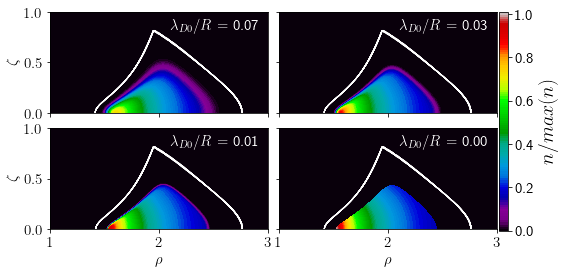

In [14]:
scale_n = 1/np.max(n4)#e**2*R_coil**2/(T0*T[0])

maxi = 1.02
mini = 0#np.min(n4*10**-mag_n)
contours_n = np.arange(mini, maxi, (maxi-mini)/100)
contour_mask = np.arange(0, 1.1, 0.1)

fig, axs = plt.subplots(2, 2, sharex='col', sharey='row', gridspec_kw={'wspace': 0.05, 'hspace': 0.15}, figsize=(8, 4))
((ax1, ax2), (ax3, ax4)) = axs

mask, phi_min = dt.well(-phi1-phi_rot, res_r, res_z, i_oe, i_mid, i_bottom, 0)
im1 = ax1.contourf(r[i_coil:]/R_coil, z/R_coil, np.transpose(scale_n*n1[i_coil:, :]), contours_n, cmap='nipy_spectral')
im_mask = ax1.contour(r[i_coil:]/R_coil, z/R_coil, np.transpose(mask[i_coil:, :]), contour_mask, colors='w', linewidths=1)
ax1.set_ylabel(r"$\zeta$", fontsize = 15)
ax1.tick_params(axis ='both', labelsize=15)
ax1.text(2.1, 0.8, r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[0]/(4*np.pi*e**2*n0))/R_coil), color = 'w', fontsize=15)

mask, phi_min = dt.well(-phi2-phi_rot, res_r, res_z, i_oe, i_mid, i_bottom, 0)
im2 = ax2.contourf(r[i_coil:]/R_coil, z/R_coil, np.transpose(scale_n*n2[i_coil:, :]), contours_n, cmap='nipy_spectral')
im_mask = ax2.contour(r[i_coil:]/R_coil, z/R_coil, np.transpose(mask[i_coil:, :]), contour_mask, colors='w', linewidths=1)
ax2.tick_params(axis ='both', labelsize=15)
ax2.text(2.1, 0.8, r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[1]/(4*np.pi*e**2*n0))/R_coil), color = 'w', fontsize=15)

mask, phi_min = dt.well(-phi3-phi_rot, res_r, res_z, i_oe, i_mid, i_bottom, 0)
im3 = ax3.contourf(r[i_coil:]/R_coil, z/R_coil, np.transpose(scale_n*n3[i_coil:, :]), contours_n, cmap='nipy_spectral')
im_mask = ax3.contour(r[i_coil:]/R_coil, z/R_coil, np.transpose(mask[i_coil:, :]), contour_mask, colors='w', linewidths=1)
ax3.set_xlabel(r"$\rho$", fontsize = 15)
ax3.set_ylabel(r"$\zeta$", fontsize = 15)
ax3.tick_params(axis ='both', labelsize=15)
ax3.text(2.1, 0.8, r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[2]/(4*np.pi*e**2*n0))/R_coil), color = 'w', fontsize=15)

mask, phi_min = dt.well(-phi4-phi_rot, res_r, res_z, i_oe, i_mid, i_bottom, 0)
im4 = ax4.contourf(r[i_coil:]/R_coil, z/R_coil, np.transpose(scale_n*n4[i_coil:, :]), contours_n, cmap='nipy_spectral')
im_mask = ax4.contour(r[i_coil:]/R_coil, z/R_coil, np.transpose(mask[i_coil:, :]), contour_mask, colors='w', linewidths=1)
ax4.set_xlabel(r"$\rho$", fontsize = 15)
ax4.tick_params(axis ='both', labelsize=15)
ax4.text(2.1, 0.8, r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[3]/(4*np.pi*e**2*n0))/R_coil), color = 'w', fontsize=15)

cb_ax = fig.add_axes([0.905, 0.12, 0.015, 0.76])
cbar = fig.colorbar(im4, cax=cb_ax, ticks = np.arange(0, 1.2, 0.2))
tick_labels = [str(abs(round(i, 1))) for i in np.arange(0, 1.2, 0.2)]
cbar.ax.set_yticklabels(tick_labels, fontsize=15) 
cbar.set_label(label = '$n/max(n)$',fontsize=20)
#plt.subplots_adjust(bottom=0.15)
plt.savefig('Steinbrunner_Fig4.png', format = 'png', bbox_inches="tight", dpi=300)
plt.savefig('Steinbrunner_Fig4.tif', format = 'tif', bbox_inches="tight", dpi=300)


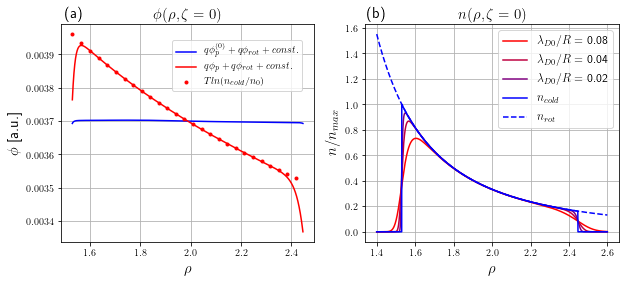

In [15]:
check = 0
for i in range(i_oe+1, res_r):
    if check == 0 and n4[i, 0] > 0:
        i_min = i
        check = 1
    if check == 1 and n4[i, 0] <= 0:     
        i_max = i
        break
        
i_left = np.argmin(abs(r/R_coil-1.4))
i_right = np.argmin(abs(r/R_coil-2.6))
i_left1 = np.argmin(abs(r/R_coil-2.4))
i_right1 = np.argmin(abs(r/R_coil-1.6))
        
scaling = c**2/(omega*I*R_coil)
offset1 = (np.min(-phi_rot[i_min:i_max, 0])-np.min(phi4[i_min:i_max, 0]))
offset2 = -(phi2[(i_max+i_min)//2, 0]+phi_rot[(i_max+i_min)//2, 0])+(0.1*T0/e)*np.log(n4[(i_max+i_min)//2, 0])
offset3 = -(phi4[(i_max+i_min)//2, 0]+phi_rot[(i_max+i_min)//2, 0])+(0.1*T0/e)*np.log(n4[(i_max+i_min)//2, 0])

fig, axs = plt.subplots(1, 2, gridspec_kw={'wspace': 0.2}, figsize=(10, 4))
(ax1, ax2) = axs

ax1.plot(r[i_min:i_max]/R_coil, scaling*((phi4[i_min:i_max, 0]+phi_rot[i_min:i_max, 0])+offset3), 'b', label = r'$q\phi_{p}^{(0)}+q\phi_{rot} + const.$')
ax1.plot(r[i_min:i_max]/R_coil, scaling*((phi2[i_min:i_max, 0]+phi_rot[i_min:i_max, 0])+offset2), 'r', label = r'$q\phi_{p}+q\phi_{rot} + const.$')
ax1.plot(r[i_min:i_max:80]/R_coil, scaling*(0.1*T0/e)*np.log(n4[i_min:i_max:80, 0]), 'ro', label = r'$Tln(n_{cold}/n_0)$', markersize = 3)
#ax1.plot(r[i_min:i_left1:75]/R_coil, scaling*(0.1*T0/e)*(np.log(n4[i_min:i_left1:75, 0])+np.log(n2[i_min:i_left1:75, 0]/n4[i_min:i_left1:75, 0])), 'r+', label = r'$Tln(n_{warm}/n_0)$')
#ax1.plot(r[i_left1:i_max:15]/R_coil, scaling*(0.1*T0/e)*(np.log(n4[i_left1:i_max:15, 0])+np.log(n2[i_left1:i_max:15, 0]/n4[i_left1:i_max:15, 0])), 'r+')
#ax1.plot(r[i_min:i_right1:10]/R_coil, scaling*(0.1*T0/e)*(np.log(n4[i_min:i_right1:10, 0])+np.log(n2[i_min:i_right1:10, 0]/n4[i_min:i_right1:10, 0])), 'r+')
ax1.set_ylabel(r'$\phi$ [a.u.]', fontsize = 15)
ax1.set_xlabel(r'$\rho$', fontsize = 15)
ax1.grid()
ax1.legend(bbox_to_anchor=(0.42, 0.67), fontsize = 10)
ax1.set_title(r'$\phi(\rho, \zeta = 0)$', fontsize=15)
ax1.text(1.5, 0.00401, '(a)', fontsize=15)

ax2.plot(r[i_left:i_right]/R_coil, n1[i_left:i_right, 0]/np.max(n4[i_left:i_right, 0]), label = r'$\lambda_{D0}/R$ = 0.08', color = (1, 0, 0, 1))
ax2.plot(r[i_left:i_right]/R_coil, n2[i_left:i_right, 0]/np.max(n4[i_left:i_right, 0]), label = r'$\lambda_{D0}/R$ = 0.04', color = (0.75, 0.0, 0.25, 1))
ax2.plot(r[i_left:i_right]/R_coil, n3[i_left:i_right, 0]/np.max(n4[i_left:i_right, 0]), label = r'$\lambda_{D0}/R$ = 0.02', color = (0.5, 0.0, 0.5, 1))
ax2.plot(r[i_left:i_right]/R_coil, n4[i_left:i_right, 0]/np.max(n4[i_left:i_right, 0]), label = r'$n_{cold}$', color = (0, 0, 1, 1))
ax2.plot(r[i_left:i_right]/R_coil, 2*omega*Bz[i_left:i_right, 0]/(c*4*np.pi*q*np.max(n4[i_left:i_right, 0])), label = r'$n_{rot}$', color = (0, 0, 1, 1), linestyle='dashed')
ax2.set_xlabel(r'$\rho$', fontsize = 15)
ax2.set_ylabel(r'$n/n_{max}$', fontsize = 15)
ax2.grid()
ax2.legend(fontsize = 12)
ax2.set_title(r'$n(\rho, \zeta = 0)$', fontsize=15)
ax2.text(1.35, 1.68, '(b)', fontsize=15)
plt.savefig('Steinbrunner_Fig5.png', format = 'png', bbox_inches="tight", dpi=300)
plt.savefig('Steinbrunner_Fig5.tif', format = 'tif', bbox_inches="tight", dpi=300)
plt.show()

In [16]:
np.std(phi4[i_min:i_max, 0]+phi_rot[i_min:i_max, 0]+offset3)/np.mean(phi4[i_min:i_max, 0]+phi_rot[i_min:i_max, 0]+offset3)

0.0006976107878197773

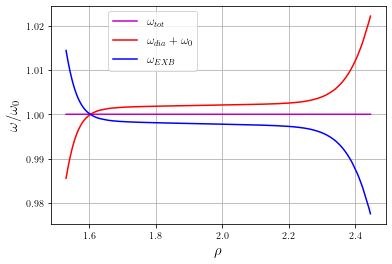

In [17]:
phi_el = phi1 - phi_trap
omega_EXB, omega_Dia, omega_cent = dt.Rotation(phi_el, psi, mask, n1, 0.5*T0, q, c, me, omega, dr, dz, r, res_r, res_z)
omega_tot = omega_EXB-omega_Dia-omega_cent

fig, ax1 = plt.subplots()
color = 'r'
ax1.set_xlabel(r'$\rho$', fontsize = 15)
ax1.set_ylabel('$\omega/\omega_0$', fontsize = 15)
#ax1.plot(r[i_l:i_r]/R_coil, (i_r-i_l)*[1], label='Reference Frame', color = 'r', linestyle='dotted')
ax1.plot(r[i_min:i_max]/R_coil, omega_tot[i_min:i_max, 1]/omega, label='$\omega_{tot}$', color = 'm')
ax1.plot(r[i_min:i_max]/R_coil, -omega_Dia[i_min:i_max, 1]/omega+1, label='$\omega_{dia}+\omega_0$', color = 'r')
ax1.plot(r[i_min:i_max]/R_coil, omega_EXB[i_min:i_max, 1]/omega, label='$\omega_{EXB}$', color = 'b')
#ax1.plot(r[i_min:i_max]/R_coil, -omega_cent[i_min:i_max, 1]/omega+1, label='$\omega_{cent}+\omega_0$', color = 'k', linestyle = 'dotted')
plt.grid()
fig.legend(bbox_to_anchor=(0.47, 0.9), fontsize = 12)
plt.savefig('Steinbrunner_Fig6.png', format = 'png', bbox_inches="tight", dpi=300)
plt.savefig('Steinbrunner_Fig6.tif', format = 'tif', bbox_inches="tight", dpi=300)
plt.show()

In [18]:
print('N_warm = %1.2e' %(dt.N_tot(n1, r, z, dr, dz, res_r, res_z)))
print('N_cold = %1.2e' %(dt.N_tot(n4, r, z, dr, dz, res_r, res_z)))
print('max(omega_cent)/omega0 = %1.2e' %(np.max(abs(omega_cent))/omega))
omega_cz_min = q*np.min(Bz[:, 0]/(me*c))
print('omega_0/min(omega_cz) = %1.2e' %(omega/omega_cz_min))

N_warm = 1.07e+10
N_cold = 1.07e+10
max(omega_cent)/omega0 = 4.61e-04
omega_0/min(omega_cz) = 3.65e-07
